## L2 cost

In [1]:
from sklearn import datasets
import scanpy as sc
import optax
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import numpy as np

import ott
import sklearn
import matplotlib.pyplot as plt
from ott.geometry import geometry, pointcloud
import jax
from typing import Mapping, Any, Optional, Union, Callable, Tuple
from types import MappingProxyType
import jax.numpy as jnp
from functools import partial
from ott.solvers.linear import sinkhorn
from ott.problems.linear import linear_problem
from genot.models.model import GENOT
#from entot.nets.nets import MLP_vector_field, MLP_bridge, MLP_marginal,MLP_fused_vector_field
from genot.nets.nets import MLP_vector_field, MLP_marginal
import sklearn.preprocessing as pp
import scanpy as sc
from ott.solvers.linear import sinkhorn, acceleration
from sklearn import preprocessing as pp

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/py

In [2]:
adata_l2 = sc.read("../../../../data/pancreas_genot.h5ad")

sc.pp.pca(adata_l2, n_comps=30)

In [3]:
(adata_l2.obs["day"].values == np.sort(adata_l2.obs["day"].values)).all()

True

In [4]:
source_train_l2 = adata_l2[adata_l2.obs["day"]=="14.5"].obsm["X_pca"]
target_train_l2 = adata_l2[adata_l2.obs["day"]=="15.5"].obsm["X_pca"]

In [5]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target_train_l2.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)

genot_l2 = GENOT(neural_net, 
              ot_solver=ot_solver,
              epsilon=1e-2,
              scale_cost="mean",
              input_dim=30,
              output_dim=30,
              iterations=10_000,
              k_noise_per_x=1,
              seed=2)

In [6]:
genot_l2(source_train_l2, target_train_l2, 1024, 1024)

I0000 00:00:1732110361.413483 1373071 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3257 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB MIG 3g.20gb, pci bus id: 0000:c3:00.0, compute capability: 8.0
100%|██████████| 10000/10000 [10:59<00:00, 15.16it/s]


In [7]:
push_train_l2 = [None] * 30

for i in range(30):
    push_train_l2[i] = genot_l2.transport(source_train_l2, seed=i)[0][0,...] - source_train_l2

In [8]:
from typing import Any, Iterable, Tuple

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from joblib import Parallel, delayed


def sample_velocities_from_transport_matrix(
    transport_matrix: np.ndarray, target_distribution: np.ndarray, n_samples: int
) -> np.ndarray:
    res = [None] * n_samples
    for i in range(n_samples):
        res[i] = target_distribution[
            jax.vmap(lambda x: jax.random.categorical(jax.random.PRNGKey(i), x))(jnp.log(transport_matrix))
        ]
    return jnp.asarray(res)


def compute_statistics_from_samples(
    samples: np.ndarray, split_to_k_batches: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    batch_size = samples.shape[0] // split_to_k_batches
    assert samples.shape[0] % split_to_k_batches == 0
    # samples is of shape (n_samples, n_cells, dim_velocity_vector)
    df = pd.DataFrame(index=cell_names)

    for i in range(split_to_k_batches):
        df[f"var_{i}"] = np.sum(np.var(samples[i * batch_size : (i + 1) * batch_size, ...], axis=0), axis=1)
        var_cols = [f"var_{i}" for i in range(split_to_k_batches)]

    df["var_of_variance"] = df[var_cols].var(axis=1)
    df["mean_of_variance"] = df[var_cols].mean(axis=1)
    return df


def compute_directional_statistics_from_samples(
    samples: np.ndarray, n_jobs: int, cell_names: Iterable[str]
) -> pd.DataFrame:
    samples = np.asarray(samples)
    n_cells = len(cell_names)
    df = pd.DataFrame(index=cell_names)
    df["directional_variance"] = np.nan
    df["directional_difference"] = np.nan
    df["directional_cosine_sim_variance"] = np.nan
    df["directional_cosine_sim_difference"] = np.nan
    df["directional_cosine_sim_mean"] = np.nan
    results = Parallel(n_jobs=n_jobs, verbose=3)(
        delayed(_directional_statistics_per_cell)(samples[:, cell_index, :]) for cell_index in range(n_cells)
    )
    # cells by samples
    cosine_sims = np.stack([results[i][0] for i in range(n_cells)])
    df.loc[:, "directional_cosine_sim_variance"] = [results[i][1] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_difference"] = [results[i][2] for i in range(n_cells)]
    df.loc[:, "directional_variance"] = [results[i][3] for i in range(n_cells)]
    df.loc[:, "directional_difference"] = [results[i][4] for i in range(n_cells)]
    df.loc[:, "directional_cosine_sim_mean"] = [results[i][5] for i in range(n_cells)]

    return df, cosine_sims


def _cosine_sim(v1: np.ndarray, v2: np.ndarray) -> np.ndarray:
    """Returns cosine similarity of the vectors."""
    v1_u = _centered_unit_vector(v1)
    v2_u = _centered_unit_vector(v2)
    return np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)


def _directional_statistics_per_cell(
    tensor: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Internal function for parallelization.

    Parameters
    ----------
    tensor
        Shape of samples by genes for a given cell.
    """
    n_samples = tensor.shape[0]
    # over samples axis
    mean_velocity_of_cell = tensor.mean(0)
    cosine_sims = [_cosine_sim(tensor[i, :], mean_velocity_of_cell) for i in range(n_samples)]
    angle_samples = [np.arccos(el) for el in cosine_sims]
    return (
        cosine_sims,
        np.var(cosine_sims),
        np.percentile(cosine_sims, 95) - np.percentile(cosine_sims, 5),
        np.var(angle_samples),
        np.percentile(angle_samples, 95) - np.percentile(angle_samples, 5),
        np.mean(cosine_sims),
    )


def _centered_unit_vector(vector: np.ndarray) -> np.ndarray:
    """Returns the centered unit vector of the vector."""
    vector = vector - np.mean(vector)
    return vector / np.linalg.norm(vector)

In [9]:
adata_l2_source = adata_l2[adata_l2.obs["day"]=="14.5"]

In [10]:
cosine_vars_source_l2 = compute_directional_statistics_from_samples(np.array(push_train_l2), 2, adata_l2_source.obs_names)

/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   16.6s
[Parallel(n_jobs=2)]: Done 4414 out of 4417 | elapsed:   20.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 4417 out of 4417 | elapsed:   20.2s finished


In [11]:
adata_l2.obs["directional_cosine_sim_variance"] = cosine_vars_source_l2[0]["directional_cosine_sim_variance"]

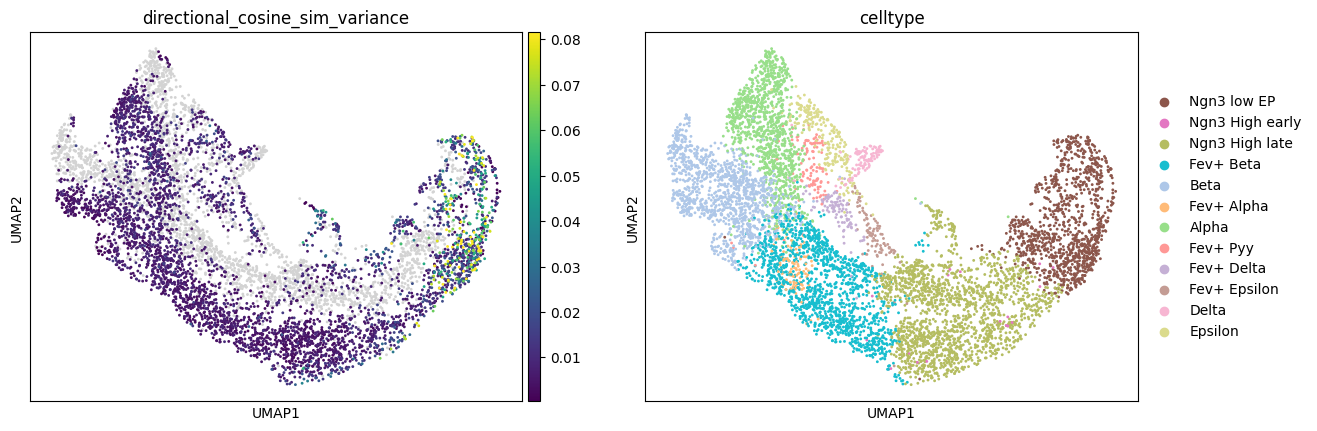

In [12]:
sc.pl.umap(adata_l2, color=["directional_cosine_sim_variance", "celltype"], vmax="p99", )

In [13]:
cell_types = ["Ngn3 low EP", "Ngn3 High early", "Ngn3 High late", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+ Epsilon", "Fev+ Pyy", "Alpha", "Beta", "Delta", "Epsilon"]
adata_l2.obs["cell_type_ordered"] = pd.Categorical(adata_l2.obs.celltype, categories=cell_types, ordered=True)

Text(0.5, 0, 'Cell type')

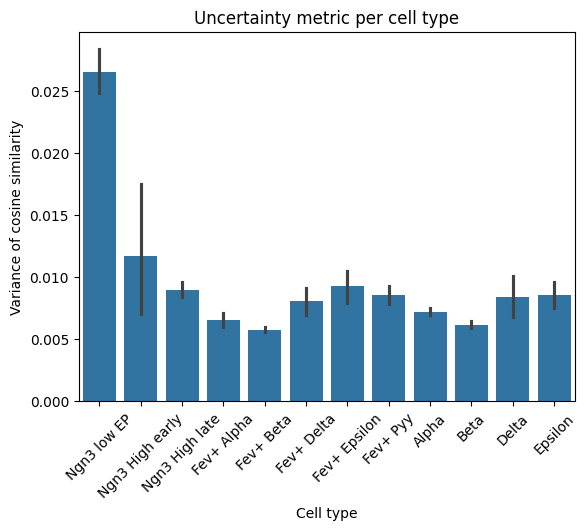

In [14]:
import seaborn as sns
g = sns.barplot(adata_l2.obs, x="cell_type_ordered", y="directional_cosine_sim_variance")
#g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.tick_params("x", labelrotation=45)
g.set_title("Uncertainty metric per cell type")
g.set_ylabel("Variance of cosine similarity")
g.set_xlabel("Cell type")

In [15]:
adata_l2.obsm["velocities"] = np.asarray(genot_l2.transport(adata_l2.obsm["X_pca"], seed=0)[0][0,...] - adata_l2.obsm["X_pca"])

In [16]:
preds_l2_3 = adata_l2.obsm["velocities"] + adata_l2.obsm["X_pca"] 

## Geodesic cost

In [17]:
adata_geo = sc.read("../../../../data/pancreas_genot.h5ad")
sc.pp.pca(adata_geo, n_comps=30)

In [18]:
(adata_geo.obs["day"].values == np.sort(adata_geo.obs["day"].values)).all()

True

In [19]:
source_train_geo = adata_geo[adata_geo.obs["day"]=="14.5"].obsm["X_pca"]
target_train_geo = adata_geo[adata_geo.obs["day"]=="15.5"].obsm["X_pca"]

In [20]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()
neural_net = MLP_vector_field(target_train_geo.shape[1], latent_embed_dim = 256, num_layers=8, n_frequencies=128)

genot_geo = GENOT(neural_net, 
              ot_solver=ot_solver, 
              cost_fn="graph", 
              graph_kwargs={"k_neighbors": 256}, 
              epsilon=1e-2, 
              scale_cost="mean", 
              input_dim=30, 
              output_dim=30, 
              iterations=5_000, 
              k_noise_per_x=1, 
              seed=2)

In [21]:
genot_geo(source_train_geo, target_train_geo, 1024, 1024)

100%|██████████| 5000/5000 [31:19<00:00,  2.66it/s] 


In [22]:
push_train_geo = [None] * 30

for i in range(30):
    push_train_geo[i] = genot_geo.transport(source_train_geo, seed=i)[0][0,...] - source_train_geo

In [23]:
adata_geo_source = adata_geo[adata_geo.obs["day"]=="14.5"]

In [24]:
cosine_vars_source = compute_directional_statistics_from_samples(np.array(push_train_geo), 2, adata_geo_source.obs_names)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/home/icb/leon.stadelmann/miniconda3/envs/genot/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   17.3s
[Parallel(n_jobs=2)]: Done 4417 out of 4417 | elapsed:   21.0s finished


In [25]:
adata_geo.obs["directional_cosine_sim_variance"] = cosine_vars_source[0]["directional_cosine_sim_variance"]

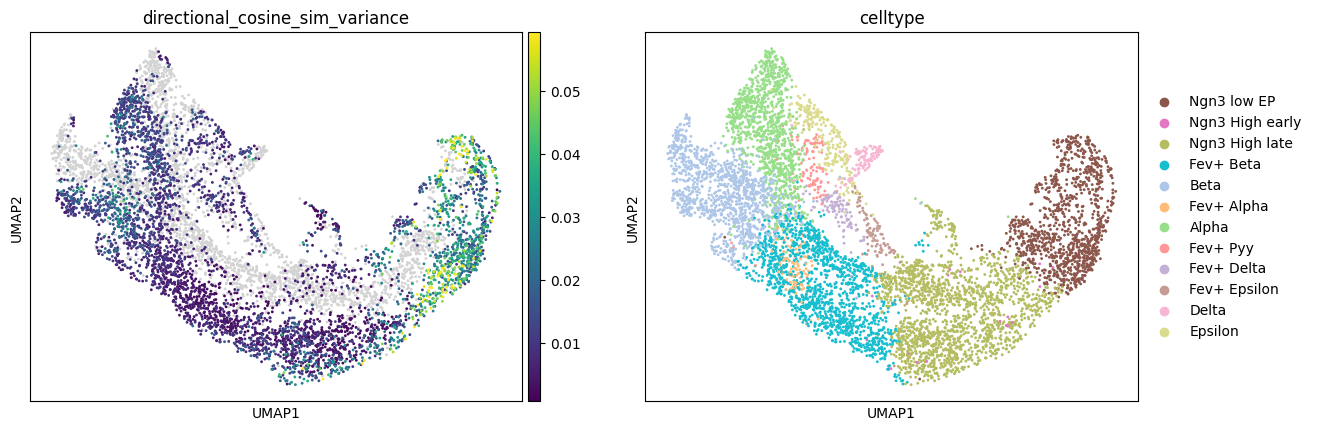

In [26]:
sc.pl.umap(adata_geo, color=["directional_cosine_sim_variance", "celltype"], vmax="p99", )

In [27]:
cell_types = ["Ngn3 low EP", "Ngn3 High early", "Ngn3 High late", "Fev+ Alpha", "Fev+ Beta", "Fev+ Delta", "Fev+ Epsilon", "Fev+ Pyy", "Alpha", "Beta", "Delta", "Epsilon"]
adata_geo.obs["cell_type_ordered"] = pd.Categorical(adata_geo.obs.celltype, categories=cell_types, ordered=True)

/tmp/ipykernel_1373071/3274407969.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')


Text(0.5, 0, 'Cell type')

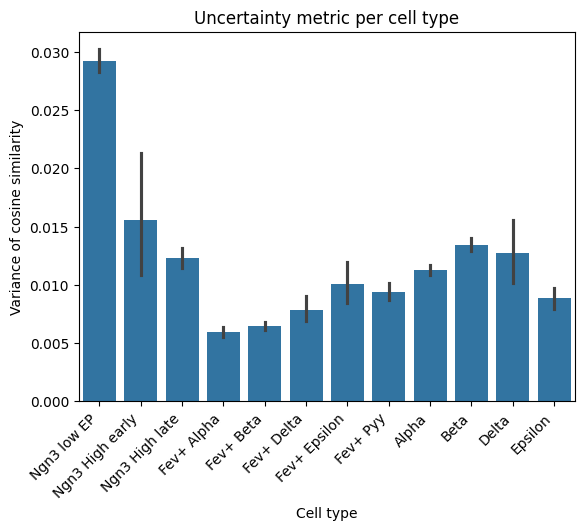

In [28]:
g = sns.barplot(adata_geo.obs, x="cell_type_ordered", y="directional_cosine_sim_variance")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Uncertainty metric per cell type")
g.set_ylabel("Variance of cosine similarity")
g.set_xlabel("Cell type")

In [29]:
adata_geo.obsm["velocities"] = np.asarray(genot_geo.transport(adata_geo.obsm["X_pca"], seed=0)[0][0,...] - adata_geo.obsm["X_pca"])

In [30]:
preds_geo_3= adata_geo.obsm["velocities"] + adata_geo.obsm["X_pca"] 

## Allocate results

In [31]:
adatas = [adata_l2, adata_geo]
preds = [preds_l2_3, preds_geo_3]
agg_tms = [None] * 2

In [32]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp
import jax.numpy as jnp
import jax
import pandas as pd

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  
        predicted_tgt_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(predicted_tgt_cells), batch_size):
            _, indices = get_knn_fn(predicted_tgt_cells[index : index + batch_size], tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(predicted_tgt_cells) - index)), min(k, len(tgt_cells)))
            )
        ri = jnp.concatenate(row_indices)
        ci = jnp.concatenate(column_indices)
        mat = np.zeros((len(ri), len(tgt_cells)))
        mat[ri,ci] = 1.0
        return mat

def aggregate_transport_matrix(adata_source, adata_target, tmat, aggregation_key = "celltype", forward = True):
    df_source = adata_source.obs[aggregation_key]
    df_target = adata_target.obs[aggregation_key]

    annotations_source = adata_source.obs[aggregation_key].cat.categories
    annotations_target = adata_target.obs[aggregation_key].cat.categories

    tm = pd.DataFrame(
        np.zeros((len(annotations_source), len(annotations_target))),
        index=annotations_source,
        columns=annotations_target,
    )
    
    for annotation_src in annotations_source:
        for annotation_tgt in annotations_target:
            tm.loc[annotation_src, annotation_tgt] = tmat[
                np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
            ].sum()
    return tm.div(tm.sum(axis=int(forward)), axis=int(not forward))

In [33]:
for i, (adata, pred) in enumerate(zip(adatas, preds)):
    source = adata[adata.obs["day"]=="14.5"].obsm["X_pca"]
    target = adata[adata.obs["day"]=="15.5"].obsm["X_pca"]
    tm = project_transport_matrix(pred[adata.obs["day"]=="14.5"], target)
    adata_source = adata[adata.obs["day"]=="14.5"]
    adata_target = adata[adata.obs["day"]=="15.5"]
    agg_tms[i] = aggregate_transport_matrix(adata_source, adata_target, tm, forward=False)

In [34]:
tms_red = [None] * 2
for i, tm in enumerate(agg_tms):
    tm_red = tm[["Alpha", "Beta", "Delta", "Epsilon"]].loc[["Ngn3 low EP", "Ngn3 High late"]].T
    tm_red["cost"] = "geo" if i>0 else "l2"
    tms_red[i] = tm_red

In [35]:
df_concat = pd.concat(tms_red)

In [36]:
df_concat = df_concat.fillna(0)

In [37]:
df_concat

,Ngn3 low EP,Ngn3 High late,cost
Alpha,0.107923,0.008197,l2
Beta,0.175025,0.018682,l2
Delta,0.319149,0.042553,l2
Epsilon,0.135678,0.085427,l2
Alpha,0.062740,0.011524,geo
Beta,0.123618,0.063317,geo
Delta,0.046512,0.000000,geo
Epsilon,0.096774,0.156682,geo


<Axes: xlabel='None', ylabel='Ngn3 low EP'>

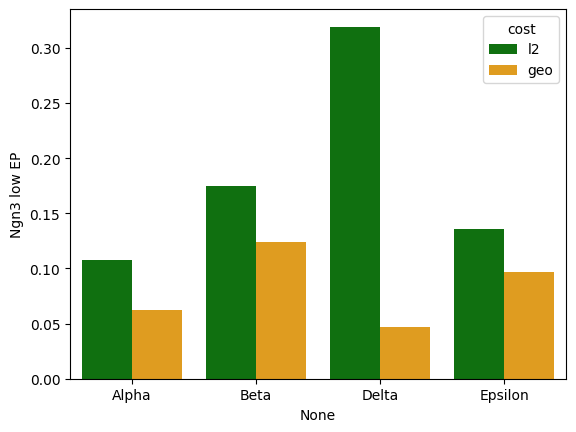

In [38]:
sns.barplot(df_concat, x=df_concat.index, y="Ngn3 low EP", hue="cost", palette=["green", "orange"], errorbar="se")

<Axes: xlabel='None', ylabel='Ngn3 High late'>

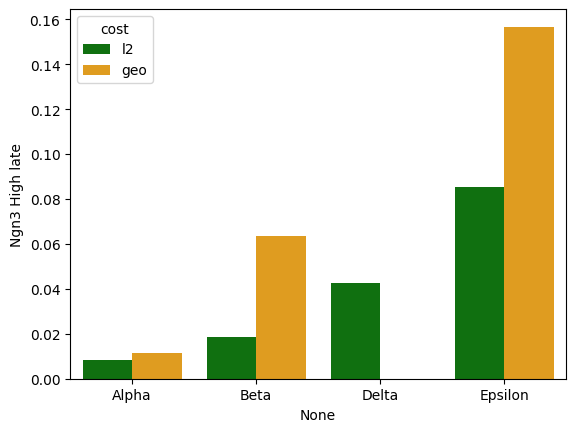

In [39]:
sns.barplot(df_concat, x=df_concat.index, y="Ngn3 High late", hue="cost", palette=["green", "orange"], errorbar="se")

In [40]:
df_concat.groupby("cost").mean()

,Ngn3 low EP,Ngn3 High late
cost,,
geo,0.082411,0.057881
l2,0.184444,0.038715


In [41]:
df_concat.groupby("cost").std()

,Ngn3 low EP,Ngn3 High late
cost,,
geo,0.034545,0.071392
l2,0.093928,0.034300


In [42]:
df_concat.groupby("cost").var()

,Ngn3 low EP,Ngn3 High late
cost,,
geo,0.001193,0.005097
l2,0.008823,0.001176


## Numeric cellrank results
### Geodesic cost

In [43]:
import cellrank
import scanpy as sc
from cellrank.kernels import VelocityKernel
sc.pp.neighbors(adata_geo)

In [44]:
kernel_geo = VelocityKernel(adata_geo, attr="obsm", xkey="velocities", vkey="velocities")

In [45]:
kernel_geo.compute_transition_matrix()

100%|██████████| 7197/7197 [00:01<00:00, 5959.70cell/s]


VelocityKernel[n=7197, model='deterministic', similarity='correlation', softmax_scale=1.942]

In [46]:
g_geo = cellrank.estimators.GPCCA(kernel_geo)

In [53]:
g_geo.tsi(n_macrostates=15, cluster_key="celltype", terminal_states=["Alpha", "Beta", "Delta", "Epsilon"])

ValueError: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.

### L2 cost

In [48]:
sc.pp.neighbors(adata_l2)

In [49]:
kernel_l2 = VelocityKernel(adata_l2, attr="obsm", xkey="velocities", vkey="velocities")

In [50]:
kernel_l2.compute_transition_matrix()

100%|██████████| 7197/7197 [00:01<00:00, 5234.81cell/s]


VelocityKernel[n=7197, model='deterministic', similarity='correlation', softmax_scale=1.88]

In [51]:
g_l2 = cellrank.estimators.GPCCA(kernel_l2)

In [57]:
g_l2.tsi(n_macrostates=15, cluster_key="celltype", terminal_states=["Alpha", "Beta", "Delta", "Epsilon"])

ValueError: Discretizing leads to a cluster with `1` samples, less than the threshold which is `6` samples. Consider recomputing the fuzzy clustering.